# Benchmark Throughput experiment (Switch)
This notebook will show you how to measure the throughput between two Alveo nodes using the benchmark application with UDP as a transport protocol.
We are going to rely on a Dask cluster to configure the local and remote Alveo cards.

This notebook assumes:
* The Alveo cards are connected to a switch
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

In [1]:
from vnx_utils import *
import pynq

In [2]:
import sys
import os

In [3]:
workers = pynq.Device.devices

## Download xclbin to Alveo cards
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [4]:
xclbin = '/home/ubuntu/Projects/StaRR-NIC/xup_vitis_network_example/benchmark.intf3.xilinx_u280_xdma_201920_3/vnx_benchmark_if3.xclbin'
ol_w0 = pynq.Overlay(xclbin, device=workers[0])

## Check Link 

We are going to use the function `linkStatus` that reports if the CMAC is detecting link, which means that the physical connection
between each Alveo card and the switch is established.

In [5]:
print("Link worker 0_0 {}, worker 0_1 {}".format(ol_w0.cmac_0.linkStatus(), ol_w0.cmac_1.linkStatus()))

Link worker 0_0 {'cmac_link': True}, worker 0_1 {'cmac_link': True}


## Configure IP address of the Alveo cards
In the next cell we are going to configure the IP address of the two Alveo cards

In [6]:
ip_w0_0, ip_w0_1 = '10.0.0.47', '10.0.0.45'
if_status_w0_0 = ol_w0.networklayer_0.updateIPAddress(ip_w0_0, debug=True)
if_status_w0_1 = ol_w0.networklayer_1.updateIPAddress(ip_w0_1, debug=True)
print("Worker 0_0: {}\nWorker 0_1: {}".format(if_status_w0_0, if_status_w0_1))

Worker 0_0: {'HWaddr': '00:0a:35:02:9d:2f', 'inet addr': '10.0.0.47', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}
Worker 0_1: {'HWaddr': '00:0a:35:02:9d:2d', 'inet addr': '10.0.0.45', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}


## One way experiment with XL710

In [7]:
n3_data = {
    'ip_tx_0': '10.0.0.55',
    'ip_rx_1': '10.0.0.57',
    'mac_rx_1': '00:0a:35:bd:11:be',
    'mac_tx_0': '00:0a:35:dd:4b:c4',
    'sport': 64000,
    'dport': 64001,
}

tx_src_port, tx_dst_port = 60512, 62177
tx_dst_ip = n3_data['ip_rx_1']
tx_dst_mac = n3_data['mac_rx_1']

# The ports are from the reference of n5 (not in the packet)
rx_src_port, rx_dst_port = n3_data['dport'], n3_data['sport']
rx_src_ip = n3_data['ip_tx_0']
rx_src_mac = n3_data['mac_tx_0']

### Configure port 0

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [8]:
ol_w0.networklayer_0.resetDebugProbes()
ol_w0.networklayer_0.sockets[2] = (tx_dst_ip, tx_dst_port, tx_src_port, True)
ol_w0.networklayer_0.sockets[1] = (rx_src_ip, rx_dst_port, rx_src_port, True)
ol_w0.networklayer_0.populateSocketTable()

ol_w0.networklayer_0.arpDiscovery()
ol_w0.networklayer_0.write_arp_entry(tx_dst_mac, tx_dst_ip)
ol_w0.networklayer_0.write_arp_entry(rx_src_mac, rx_src_ip)
ol_w0.networklayer_0.readARPTable()

{45: {'MAC address': '00:0a:35:02:9d:2d', 'IP address': '10.0.0.45'},
 55: {'MAC address': '00:0a:35:dd:4b:c4', 'IP address': '10.0.0.55'},
 57: {'MAC address': '00:0a:35:bd:11:be', 'IP address': '10.0.0.57'},
 61: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.63'}}

In [9]:
ol_w0.networklayer_0.getDebugProbes

{'tx_path': {'arp': {'packets': 253, 'bytes': 15180, 'cycles': 2041},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet_header_inserter': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet': {'packets': 253, 'bytes': 15180, 'cycles': 2041},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0}},
 'rx_path': {'ethernet': {'packets': 1, 'bytes': 60, 'cycles': 1},
  'packet_handler': {'packets': 1, 'bytes': 60, 'cycles': 1},
  'arp': {'packets': 1, 'bytes': 60, 'cycles': 1},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0}}}

### Configure port 1

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [10]:
ol_w0.networklayer_1.resetDebugProbes()
ol_w0.networklayer_1.sockets[1] = (rx_src_ip, rx_dst_port, rx_src_port, True)
ol_w0.networklayer_1.populateSocketTable()

ol_w0.networklayer_1.arpDiscovery()
ol_w0.networklayer_1.write_arp_entry(tx_dst_mac, tx_dst_ip)
ol_w0.networklayer_1.write_arp_entry(rx_src_mac, rx_src_ip)
ol_w0.networklayer_1.readARPTable()

{47: {'MAC address': '00:0a:35:02:9d:2f', 'IP address': '10.0.0.47'},
 55: {'MAC address': '00:0a:35:dd:4b:c4', 'IP address': '10.0.0.55'},
 57: {'MAC address': '00:0a:35:bd:11:be', 'IP address': '10.0.0.57'},
 61: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.63'}}

In [11]:
ol_w0.networklayer_1.getDebugProbes

{'tx_path': {'arp': {'packets': 251, 'bytes': 15060, 'cycles': 2041},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet_header_inserter': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet': {'packets': 251, 'bytes': 15060, 'cycles': 2041},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0}},
 'rx_path': {'ethernet': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'packet_handler': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'arp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0}}}

## Configure application
* Configure port 1 traffic generator 1 in `CONSUMER` mode

### Configure local benchmark application
This part configures the collector, in particular
* Allocate buffers
* Start collector

In [12]:
send_packets   = 2 ** 24
shape          = (send_packets,1)
rtt_cycles     = pynq.allocate(shape, dtype=np.uint32, target=ol_w0.HBM0)
pkt            = pynq.allocate(1,     dtype=np.uint32, target=ol_w0.HBM0)

collector_h = ol_w0.collector_0_2.start(rtt_cycles,pkt)

In [21]:
send_pkts = send_packets
ol_w0_tg = ol_w0.traffic_generator_0_2
ol_w0_tg.register_map.debug_reset = 1
ol_w0.networklayer_0.register_map.debug_reset_counters = 1
ol_w0_tg.register_map.mode = benchmark_mode.index('LATENCY')
ol_w0_tg.register_map.number_packets = send_pkts
ol_w0_tg.register_map.time_between_packets = 50
ol_w0_tg.register_map.number_beats = 1
ol_w0_tg.register_map.dest_id = 2
ol_w0_tg.register_map.CTRL.AP_START = 1

In [22]:
ol_w0.networklayer_1.getDebugProbes

{'tx_path': {'arp': {'packets': 251, 'bytes': 15060, 'cycles': 2041},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet_header_inserter': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet': {'packets': 251, 'bytes': 15060, 'cycles': 2041},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0}},
 'rx_path': {'ethernet': {'packets': 7, 'bytes': 1810, 'cycles': 43502182813},
  'packet_handler': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'arp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0}}}

In [18]:
ol_w0_tg.register_map.reset_fsm = 1

In [19]:
ol_w0_tg.register_map.debug_reset = 1
ol_w0_tg.register_map.reset_fsm = 0

In [23]:
ol_w0_tg.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=1),
  dest_id = Register(value=2),
  number_packets = Register(value=16777216),
  number_beats = Register(value=1),
  time_between_packets = Register(value=50),
  reset_fsm = Register(value=0),
  debug_fsms = Register(value=0),
  out_traffic_cycles = Register(value=855637966),
  out_traffic_bytes = Register(value=301989888),
  out_traffic_packets = Register(value=16777216),
  in_traffic_cycles = Register(value=855637964),
  in_traffic_bytes = Register(value=301989888),
  in_traffic_packets = Register(value=16777216),
  summary_cycles = Register(value=855637966),
  summary_bytes = Register(value=268697872),
  summary_packets = Register(value=16793617),
  debug_reset = Register(value=0)
}

In [24]:
rtt_cycles.sync_from_device()
rtt_cycles

PynqBuffer([[676],
            [675],
            [675],
            ...,
            [677],
            [676],
            [676]], dtype=uint32)

In [25]:
len(rtt_cycles)

16777216

In [26]:
freq = int(ol_w0.clock_dict['clock0']['frequency'])
rtt_usec = np.array(shape, dtype=np.float)
rtt_usec= rtt_cycles / freq  # convert to microseconds

/tmp/ipykernel_14602/149005877.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rtt_usec = np.array(shape, dtype=np.float)


In [27]:
from scipy import stats
mean, std_dev, mode = np.mean(rtt_usec), np.std(rtt_usec), stats.mode(rtt_usec)
print("Round trip time at application level using {:,} packets".format(len(rtt_usec)))
print("\tmean    = {:.3f} us\n\tstd_dev = {:.6f} us".format(mean,std_dev))
print("\tmode    = {:.3f} us, which appears {:,} times".format(mode[0][0][0],mode[1][0][0]))
print("\tmax     = {:.3f} us".format(np.max(rtt_usec)))
print("\tmin     = {:.3f} us".format(np.min(rtt_usec)))

Round trip time at application level using 16,777,216 packets
	mean    = 2.296 us
	std_dev = 0.004664 us
	mode    = 2.296 us, which appears 5,036,172 times
	max     = 2.367 us
	min     = 2.276 us


/tmp/ipykernel_14602/1664195630.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''])


{'whiskers': [<matplotlib.lines.Line2D at 0x7f25c2ae23a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f25c32a6520>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f25c2ae2af0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f25c2af8310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f25c2af85e0>],
 'means': []}

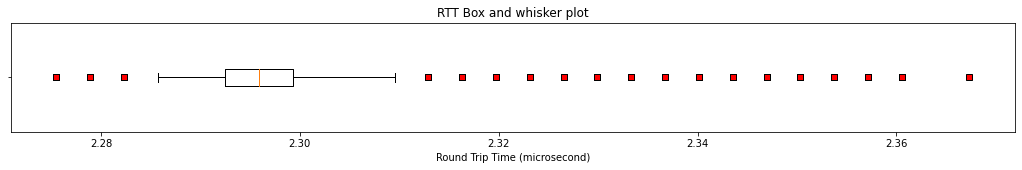

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

red_square = dict(markerfacecolor='r', marker='s')
fig, ax = plt.subplots()
ax.set_title('RTT Box and whisker plot')
ax.set_xlabel('Round Trip Time (microsecond)')
ax.set_yticklabels([''])
fig.set_size_inches(18, 2)
ax.boxplot(rtt_usec, vert=False, flierprops=red_square)

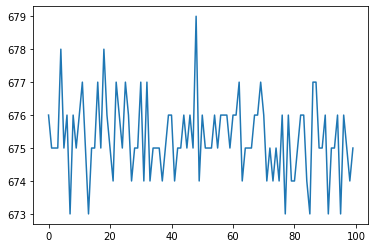

In [30]:
fig, ax = plt.subplots()
ax.plot(rtt_cycles[:100])

In [ ]:
del rtt_cycles
del pkt
pynq.Overlay.free(ol_w0)

------------------------------------------
Copyright (c) 2020-2021, Xilinx, Inc.